### The current notebook uses the electric-motor-temperature dataset to predict the rotor temperature of a motor.

The dataset and its description is available here:
https://www.kaggle.com/wkirgsn/electric-motor-temperature


The goal of the project is to efficietly predict the rotor temperature of a permanent magnet synchronous motor (PMSM), as it is usually difficult to measure the rotor temperature. This kind of prediction helps to reduce the amount of equipment that is to be mounted on to the motor to measure the temperature.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

torch.manual_seed(2)
np.random.seed(2)

In [2]:
df = pd.read_csv("./data/pmsm_temperature_data.csv")

In [3]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


##### As explained in the description the profile_id column in the data set corresponds to different measurement sessions. The most interesting target features given in description are rotor temperature('pm), stator temperatures('stator_*) and torque. 
##### All the other features are considered to be inputs features

In [4]:
col_list = df.columns.tolist()
profile_id = ['profile_id']
target_list = ['pm', 'torque', 'stator_yoke', 'stator_tooth', 'stator_winding']
feature_list = [col for col in col_list if col not in target_list and col not in profile_id]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


##### As profile id just indicates which measurement session the data belongs to, it can be treated as categorical variable, and also to make select data that is relevant to the session

In [6]:
df['profile_id'] = df.profile_id.astype('category', inplace=True)
df.profile_id.unique()

[4, 6, 10, 11, 20, ..., 78, 79, 80, 81, 72]
Length: 52
Categories (52, int64): [4, 6, 10, 11, ..., 79, 80, 81, 72]

### Since all the variables/features are measured over time and are time dependant. The later analysis is done assuming the data to be time series data.

#### For this reason, the data is split into number of time sequences. The target value for a given sequence will be the value which is just after a given sequence.

In [7]:
def build_sequences(features_df, target_df, sequence_length = 10):
    """Builds sequences from data and converts them into pytorch tensors
        sequence_length - represents the number of samples to be considered in a sequence
    """
    data_ = []
    target_ = []
    
    for i in range(int(features_df.shape[0]/sequence_length)):
        
        data = torch.from_numpy(features_df.iloc[i:i+sequence_length].values.T)
        target = torch.from_numpy(target_df.iloc[i+sequence_length+1].values.T)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    
    return data, target

In [8]:
prof_ids = list(df.profile_id.unique())
print(prof_ids)

[4, 6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 72]


###### Slecting a measurement profile to prepare the data

In [9]:
# idx = np.random.randint(len(prof_ids)))

# prof_id = prof_ids[idx]
# print('Selected profile -',prof_id)

### OR ###
prof_id = 6

curr_df = df[df['profile_id'] == prof_id]

curr_df = curr_df.drop('profile_id', axis = 1)
columns = curr_df.columns.tolist()

In [10]:
scaler = MinMaxScaler()

curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns= columns)
curr_df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,0.422350,0.064550,0.495541,0.173390,0.000066,0.605967,0.957416,0.635014,0.000142,0.000600,0.000105,0.000711
1,0.424296,0.064815,0.495157,0.174028,0.000064,0.610011,0.955582,0.640728,0.000089,0.000826,0.000087,0.000582
2,0.425627,0.064977,0.494894,0.174470,0.000063,0.612710,0.954268,0.644823,0.000089,0.000758,0.000058,0.000427
3,0.426669,0.065209,0.494701,0.174815,0.000062,0.614798,0.953327,0.647756,0.000003,0.000342,0.000021,0.000326
4,0.427242,0.065387,0.494559,0.175044,0.000060,0.616119,0.952652,0.649859,0.000000,0.000086,0.000013,0.000273


### Sequence length has to be selected prior to the model initialization

##### As the sampling is done at 2 Hz, the sequence size can be >= 2. But, keeping in view the importance of speed of operation as the values are needed for other operations or control, it should be as small as possible to reduce the delay.

##### Also, another point to be noted here is, if the sequence length is higher the prediction error is less. So there must be a trade off between the required error rate and speed (in this case the initial prediction). 

##### The delay in responce will be only at the beginning and the later predictions will not have the delay if real time operation is considered.

In [11]:
sequence_length = 5

features = curr_df[feature_list]
target = curr_df[target_list][['pm']]

data, target = build_sequences(features, target, sequence_length=sequence_length)

In [12]:
data.shape

torch.Size([8077, 7, 5])

##### Dividing the generated sequences into training and testing set

In [13]:
# Test size the percentage of data to be used for testing
test_size = 0.05

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

##### A Dataset class is needed for the data inorder to use the dataloader of Pytorch

In [14]:
class PMSMDataset(torch.utils.data.dataset.Dataset):
    """Dataset with Rotor Temperature as Target"""
    def __init__(self, data, target):
        
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx].float(), self.target[idx].float()

In [15]:
batch_size = 10

pm_train_dataset = PMSMDataset(X_train, y_train)
pm_train_loader = torch.utils.data.dataloader.DataLoader(pm_train_dataset, batch_size= batch_size)

pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size= 1)

##### The network class

In [16]:
class Network(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        self.sequence_length = sequence_length
        self.n_features = n_features
        
        self.features = nn.Sequential(
                        nn.Conv1d(n_features, 16, kernel_size=3),
                        nn.ReLU(),
                        nn.Conv1d(16,32, kernel_size=1))
        
        self.lin_in_size = self.get_lin_in_size()
        
        self.predictior = nn.Sequential(
                        nn.Linear(self.lin_in_size,30),
                        nn.ReLU(),
                        nn.Linear(30, 1))
        
    def forward(self, x):
        
        x = self.features(x)
        x = x.view(-1, self.lin_in_size)
        x = self.predictior(x)
        return x
    
    def get_lin_in_size(self):
        rand_in = torch.rand(10, self.n_features, self.sequence_length)
        rand_out = self.features(rand_in)
        return rand_out.shape[-1] * rand_out.shape[-2]
        

##### Note that the same sequence length used to generate the data should be used to create the network

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_features = X_train.shape[-2]
net = Network(sequence_length, n_features)
net = net.to(device)

In [18]:
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

### Training

In [19]:
def test(net, test_loader, criterion):
    
    net.eval()
    losses = []
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device) 
        out = net(data)
        loss = criterion(out, target)
        losses.append(loss.item())  
    
    net.train()
    return np.mean(losses)

def train(n_epochs, net, train_loader, test_loader, optimizer, criterion, interval = 10):
    net.train()
    training_losses = []
    test_losses = []
    
    for epoch in range(1,n_epochs+1):
        running_loss = 0.0
        batch_losses = []
        
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) 
            
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            batch_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
        
        training_losses.append(np.mean(batch_losses))
        
        test_losses.append(test(net, test_loader, criterion))
        
        if epoch%interval==1:
            print("Epoch {}, Training loss {:.6f}, Testing loss {:.6f}".format(epoch, training_losses[-1], test_losses[-1]))
    return training_losses, test_losses

In [20]:
training_losses, test_losses = train(50, net, pm_train_loader, pm_test_loader, optimizer, criterion)

Epoch 1, Training loss 0.025563, Testing loss 0.015755
Epoch 11, Training loss 0.000594, Testing loss 0.000649
Epoch 21, Training loss 0.000817, Testing loss 0.000333
Epoch 31, Training loss 0.000702, Testing loss 0.000333
Epoch 41, Training loss 0.000625, Testing loss 0.000325


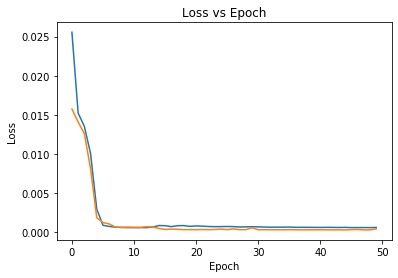

In [21]:
plt.plot(training_losses, label='Train')
plt.plot(test_losses, label ='Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Saving the model

In [22]:
torch.save(net.state_dict(), './model_single_measurement.pt')

### Testing

In [26]:
net = Network(sequence_length,n_features)
net.load_state_dict(torch.load('./model_single_measurement.pt'))
net = net.to(device)

In [27]:
def get_predictions(net, loader):
    
    net.eval()
    targets = []
    outputs = []
    
    for _, (data, target) in enumerate(loader):
        
        data, target = data.to(device), target.to(device)
        
        out = net(data)

        targets.append(target.item())
        outputs.append(out.item())
    return targets, outputs

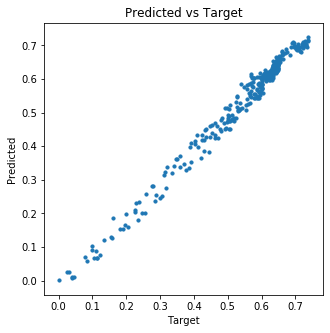

In [28]:
targets, outputs = get_predictions(net, pm_test_loader)

plt.figure(figsize=(5,5))
plt.scatter(targets, outputs, s=10)
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.title("Predicted vs Target")
plt.show()

In [29]:
print("R2 Score - ", r2_score(targets, outputs))

R2 Score -  0.9808065058466385


#### As seen in the plot the predicted value is almost equal to the target value, since the plot is a straight line. R2 Score also confirms this as it is close to 1.

#### The predictions are based on one measurement session, the next step is to train a single model on multiple measurement profiles and evaluate the performance.


In [33]:
prof_ids = list(df.profile_id.unique())
print(prof_ids)

[4, 6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 72]


#### Selecting the first 8 measurement profiles and following the steps mentioned above

##### Data preparation

In [44]:
curr_prof_ids = [4, 6, 10, 11, 20, 27, 29, 30]
sequence_length = 5

data_list = []
targets = []
for id_ in curr_prof_ids:
    curr_df = df[df['profile_id'] == id_]
    curr_df = curr_df.drop('profile_id', axis = 1)
    columns = curr_df.columns.tolist()
    
    scaler = MinMaxScaler()
    curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns= columns)

    features = curr_df[feature_list]
    target = curr_df[target_list][['pm']]

    data, target = build_sequences(features, target, sequence_length=sequence_length)   
    data_list.append(data)
    targets.append(target)

data = torch.cat(data_list)
target = torch.cat(targets)

In [45]:
data.shape, target.shape

(torch.Size([44298, 7, 5]), torch.Size([44298, 1]))

In [46]:
# Test size the percentage of data to be used for testing
test_size = 0.20

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

In [58]:
batch_size = 100

pm_train_dataset = PMSMDataset(X_train, y_train)
pm_train_loader = torch.utils.data.dataloader.DataLoader(pm_train_dataset, batch_size= batch_size)

pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size= batch_size)

##### Initializing model, optimizer and loss criterion

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_features = X_train.shape[-2]
net = Network(sequence_length, n_features)
net = net.to(device)

lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

##### Training

In [66]:
training_losses, test_losses = train(100, net, pm_train_loader, pm_test_loader, optimizer, criterion)

Epoch 1, Training loss 0.042022, Testing loss 0.022194
Epoch 11, Training loss 0.014303, Testing loss 0.013763
Epoch 21, Training loss 0.011026, Testing loss 0.010490
Epoch 31, Training loss 0.008379, Testing loss 0.008101
Epoch 41, Training loss 0.006140, Testing loss 0.005668
Epoch 51, Training loss 0.004918, Testing loss 0.004572
Epoch 61, Training loss 0.004311, Testing loss 0.004351
Epoch 71, Training loss 0.003938, Testing loss 0.003664
Epoch 81, Training loss 0.003576, Testing loss 0.003542
Epoch 91, Training loss 0.003346, Testing loss 0.003119


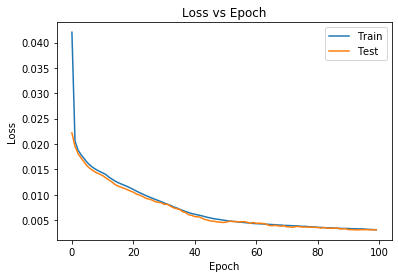

In [67]:
plt.plot(training_losses, label='Train')
plt.plot(test_losses, label ='Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

##### Saving model

In [71]:
torch.save(net.state_dict(), './model_multiple_measurement.pt')

##### Loading and testing the model

In [73]:
net = Network(sequence_length,n_features)
net.load_state_dict(torch.load('./model_multiple_measurement.pt'))
net = net.to(device)

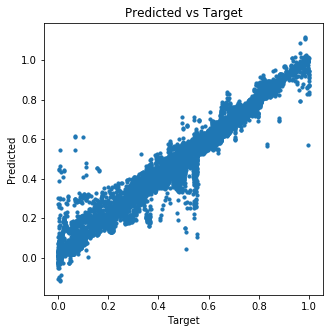

In [74]:
pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size= 1)

targets, outputs = get_predictions(net, pm_test_loader)

plt.figure(figsize=(5,5))
plt.scatter(targets, outputs, s=10)
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.title("Predicted vs Target")
plt.show()

In [75]:
print("R2 Score - ", r2_score(targets, outputs))

R2 Score -  0.9515649103752677


#### The plot between predicted value and target value is again a clase straight line. The R2 score of 0.95 confirms it.

#### The same model when trained on data obtained from different operating settings performs well even without increasing the model capacity. Further study can be done by using data from all the measurement profiles in the dataset.
